# ブロックに格納するtxの戦略を表示する

blockに格納されているtxのgasとfeeなどを格納順番通りに表示してminerの戦略を読み取るグラフを作成する

### 必要なライブラリをインポート
GraphQLを使ってローカルに立てたノードからブロック情報を一括取得して解析するのひ必要なライブライをimportする。

In [136]:
import json
from gql import gql, Client
from gql.transport.requests import RequestsHTTPTransport
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

取得するブロックの範囲を定義

In [137]:
# tip block [2022/08/27 03:06] 15,416,816
start = 15416600
end =   15416700
step = 1000

In [138]:
query = """query GetBlocks($start: Long!, $end: Long!) {
      blocks(from: $start, to: $end) {
        number,
        baseFeePerGas,
        miner {
          address
        },
        extraData,
        transactions {
          type,
          index,
          gas,
          gasUsed,
          maxPriorityFeePerGas,
          maxFeePerGas,
          gasPrice,
        }
      }
    }"""

# baseFeesをgwei単位に変換するために定義
gwei_unit = 1000000000


## go-ethereumからデータを取得

In [139]:
client = Client(
    transport=RequestsHTTPTransport(
      url = "http://192.168.10.10:8545/graphql",
      use_json = True,
      headers = {
        "Content-type": "application/json",
        "Content-Length": str(len(query))
      },
      retries = 3,
    ),
    fetch_schema_from_transport=True,
)

blocks = []
for bfrom in np.arange(start, end, step):
    bto = bfrom+step
    print(f"start={bfrom}, end={bto}")
    
    if bto > end:
        bto = end
    variable = {"start": str(bfrom+1), "end": str(bto)}
    resp = client.execute(
      gql(query),
      variable_values = variable)
    blocks.extend(resp["blocks"])
    print(f"{variable} load end. blocks.len={len(blocks)}")

print(len(blocks))
print("load OK")

start=15416600, end=15417600
{'start': '15416601', 'end': '15416700'} load end. blocks.len=100
100
load OK


## 取得したデータをグラフにプロット

In [174]:
def priorityFee(tx, baseFee):
    priority = 0
    actual_priority = 0
    maxFee = 0
    if tx['type'] == 2:
        priority = int(tx['maxPriorityFeePerGas'], 16)
        maxFee = int(tx['maxFeePerGas'], 16)
        if (maxFee - baseFee) < priority:
            actual_priority = maxFee - baseFee
    else:
        gasPrice = int(tx['gasPrice'], 16)
        maxFee = gasPrice
        priority = gasPrice - baseFee
        actual_priority = priority
    
    return (priority, actual_priority, maxFee)
    
def extraData2Str(extraData):
    sub = extraData[2:]
    return bytearray.fromhex(sub).decode(encoding='utf-8', errors='ignore')


numbers = list() # block number
miners = list() # miner address
gasLimits = list()
maxFees = list()
priorities = list()
actual_priorities = list()
useds = list()
actual_fees = list()
tx_indexes = list()
miner_name = dict()

# あとでblock番号でデータを絞り込むためにつかうindex。txの数だけ埋める。
index_numbers = list()
# あとで絞り込みに使う重複なしのminerのset
miner_set = set()

for block in blocks:
    number = block['number']
    miner = block['miner']['address']
    baseFee = int(block['baseFeePerGas'], 16)
    numbers.append(number)
    
    for tx in block['transactions']:
        priority, actualPriority, maxFee = priorityFee(tx, baseFee)
        used = tx['gasUsed']
        miner_name[miner] = extraData2Str(block['extraData'])
        
        miners.append(miner)
        miner_set.add(miner)
        
        tx_indexes.append(tx['index'])
        gasLimits.append(int(tx['gas'], 16))
        maxFees.append(maxFee)
        priorities.append(priority)
        actual_priorities.append(actualPriority)
        useds.append(used)
        actual_fees.append(actualPriority * used)
        index_numbers.append(number)


df = pd.DataFrame({
    "position": tx_indexes,
    "miners": miners,
    "gasLimit": gasLimits,
    "gasUsed": useds,
    "maxFeePerGas": maxFees,
    "maxPriorityPerGas": priorities,
    "actualPriorityPerGas": actual_priorities,
    "actual_fee": actual_fees,
}, index=index_numbers)

pd.set_option('display.max_rows', 10)
print(df.loc[start+1])
print(len(df))
print(f"miner.len: {len(miner_set)}")

miners_df_dic = dict()
for bnum in numbers:
    try:
        # bnum = start+i
        subdf = df.loc[bnum]
        mname = subdf['miners'].values[0]
        miners_df_dic[mname]=subdf
    except:
        print(f"skip: {bnum}")


          position                                      miners  gasLimit  \
15416601         0  0x829bd824b016326a401d083b33d092293333a830    309030   
15416601         1  0x829bd824b016326a401d083b33d092293333a830    300000   
15416601         2  0x829bd824b016326a401d083b33d092293333a830    177062   
15416601         3  0x829bd824b016326a401d083b33d092293333a830   1375636   
15416601         4  0x829bd824b016326a401d083b33d092293333a830    157256   
...            ...                                         ...       ...   
15416601       325  0x829bd824b016326a401d083b33d092293333a830    160555   
15416601       326  0x829bd824b016326a401d083b33d092293333a830     51612   
15416601       327  0x829bd824b016326a401d083b33d092293333a830     21000   
15416601       328  0x829bd824b016326a401d083b33d092293333a830    483154   
15416601       329  0x829bd824b016326a401d083b33d092293333a830     21000   

          gasUsed  maxFeePerGas  maxPriorityPerGas  actualPriorityPerGas  \
15416601   

## データの詳細を確認する用
実行しなくてもよい

In [ ]:
show_df = miners_df_dic[list(miner_set)[0]] # 詳細確認用
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
show_df

,position,miners,block,gasLimit,gasUsed,maxPriorityPerGas,actual_fee
15416679,0,0x8f03f1a3f10c05e7cccf75c1fd10168e06659be7,15416679,918980,718980,23849342109,0
15416679,1,0x8f03f1a3f10c05e7cccf75c1fd10168e06659be7,15416679,2496513,1274851,1600000000,0
15416679,2,0x8f03f1a3f10c05e7cccf75c1fd10168e06659be7,15416679,795400,575284,23849342109,0
15416679,3,0x8f03f1a3f10c05e7cccf75c1fd10168e06659be7,15416679,900000,364344,101000000000,0
15416679,4,0x8f03f1a3f10c05e7cccf75c1fd10168e06659be7,15416679,900000,353928,101000000000,0
15416679,5,0x8f03f1a3f10c05e7cccf75c1fd10168e06659be7,15416679,900000,353928,101000000000,0
15416679,6,0x8f03f1a3f10c05e7cccf75c1fd10168e06659be7,15416679,900000,353928,101000000000,0
15416679,7,0x8f03f1a3f10c05e7cccf75c1fd10168e06659be7,15416679,174880,129411,66150658891,8560622917743201
15416679,8,0x8f03f1a3f10c05e7cccf75c1fd10168e06659be7,15416679,100000,21000,63150657891,1326163815711000
15416679,9,0x8f03f1a3f10c05e7cccf75c1fd10168e06659be7,15416679,700000,353928,54768399852,0


# 結果をグラフにプロットする

(bnum=15416679
(bnum=15416657
(bnum=15416640
(bnum=15416605
(bnum=15416619
(bnum=15416646
(bnum=15416603
(bnum=15416632
(bnum=15416699
(bnum=15416700
(bnum=15416685


/tmp/ipykernel_4892/2685737515.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


(bnum=15416622
(bnum=15416698
(bnum=15416664
(bnum=15416690
(bnum=15416666
(bnum=15416618
(bnum=15416680
(bnum=15416694
(bnum=15416653
completede!


<Figure size 432x288 with 0 Axes>

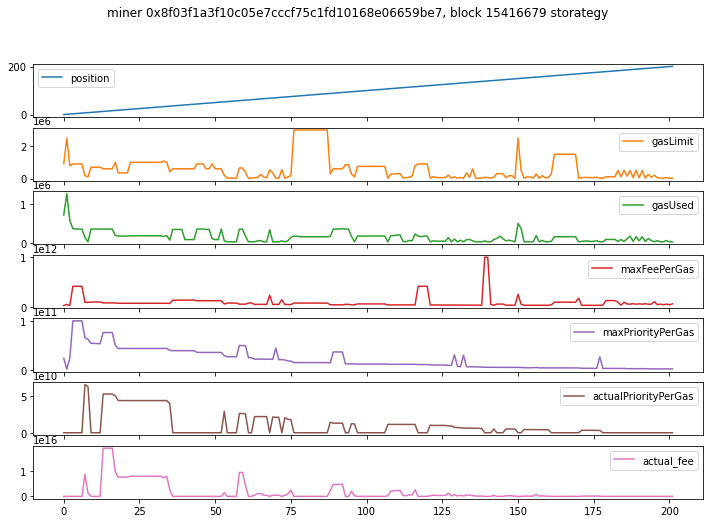

<Figure size 432x288 with 0 Axes>

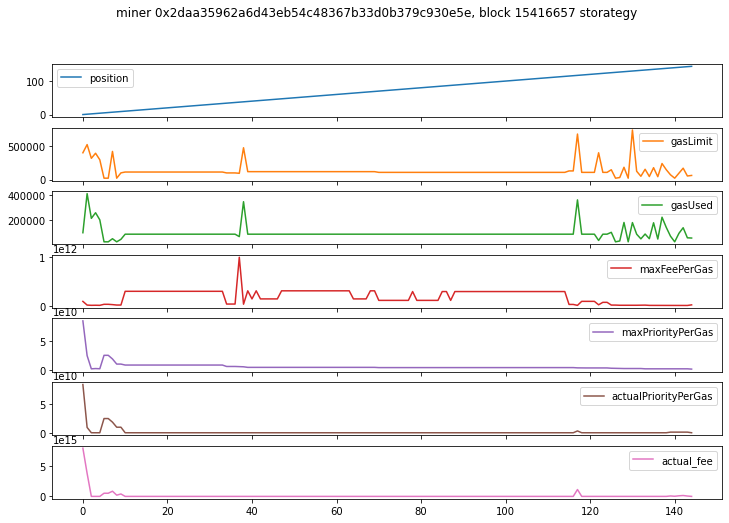

<Figure size 432x288 with 0 Axes>

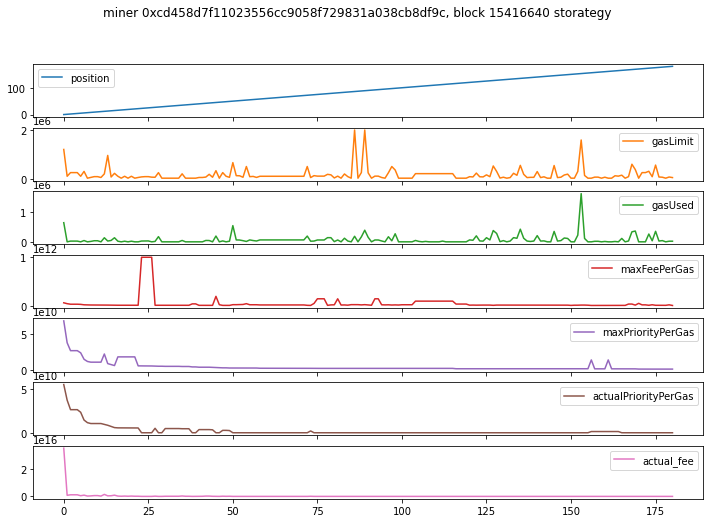

<Figure size 432x288 with 0 Axes>

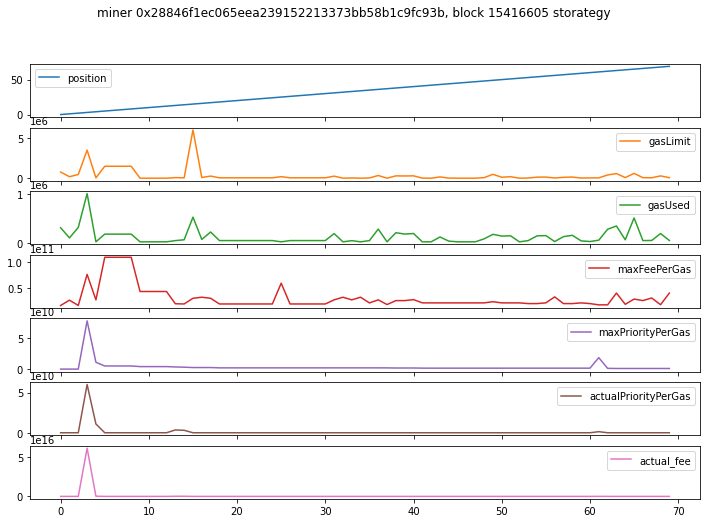

<Figure size 432x288 with 0 Axes>

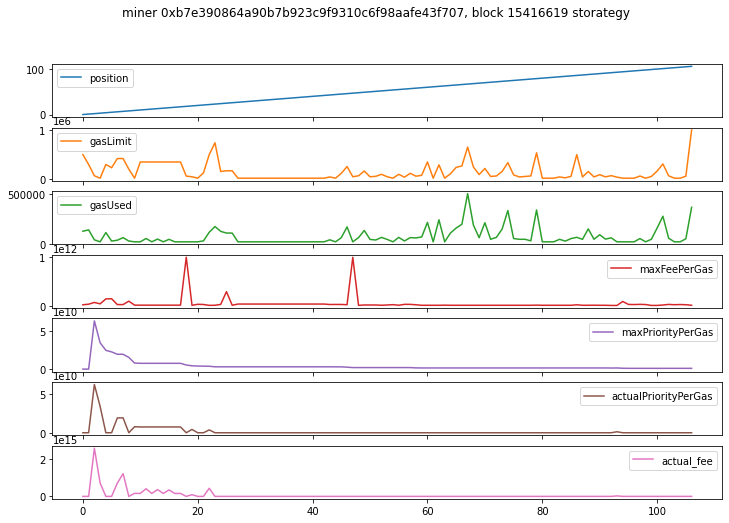

<Figure size 432x288 with 0 Axes>

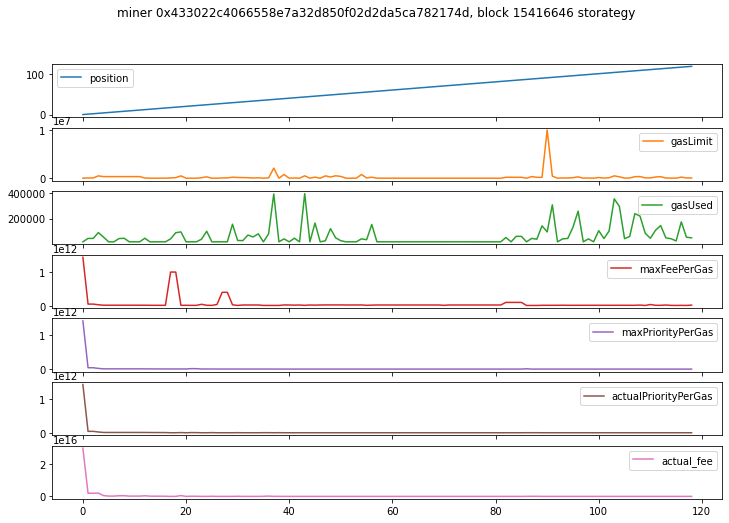

<Figure size 432x288 with 0 Axes>

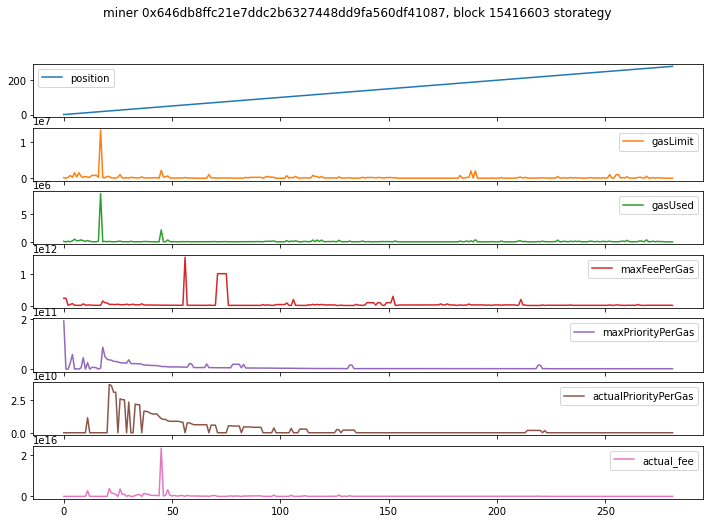

<Figure size 432x288 with 0 Axes>

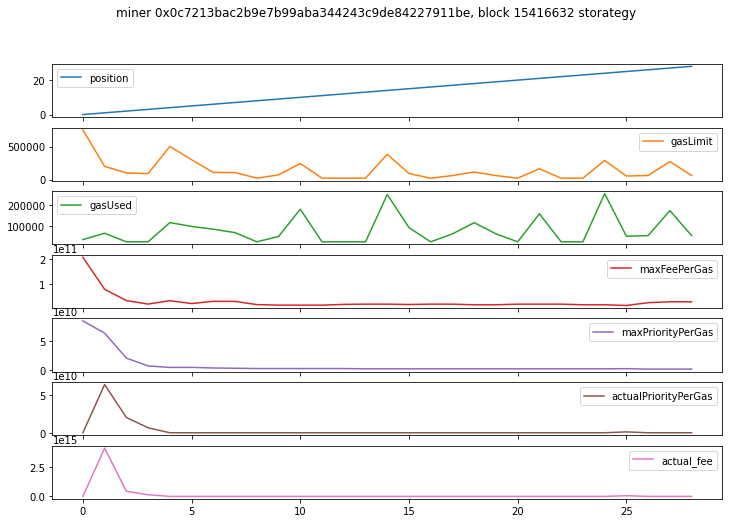

<Figure size 432x288 with 0 Axes>

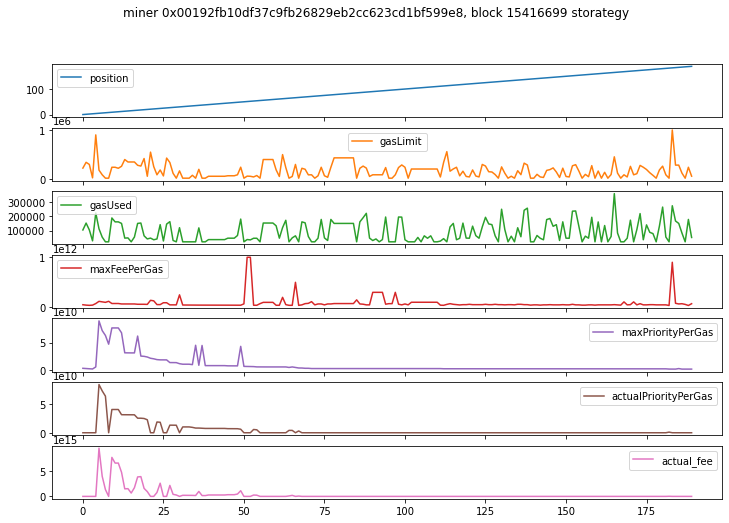

<Figure size 432x288 with 0 Axes>

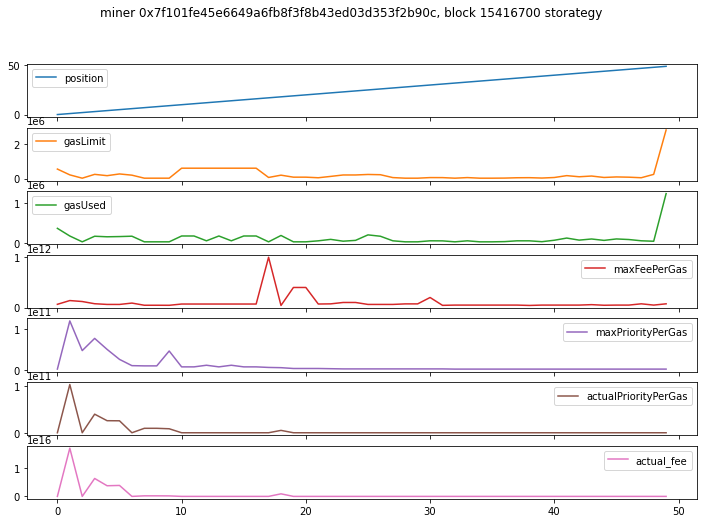

<Figure size 432x288 with 0 Axes>

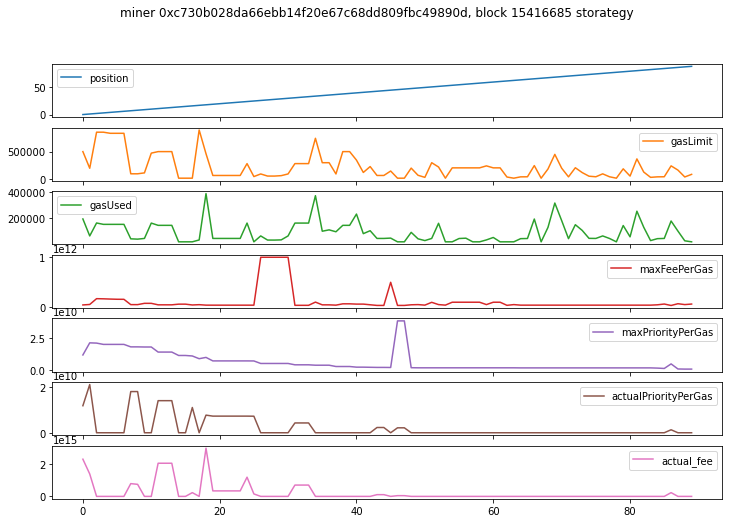

<Figure size 432x288 with 0 Axes>

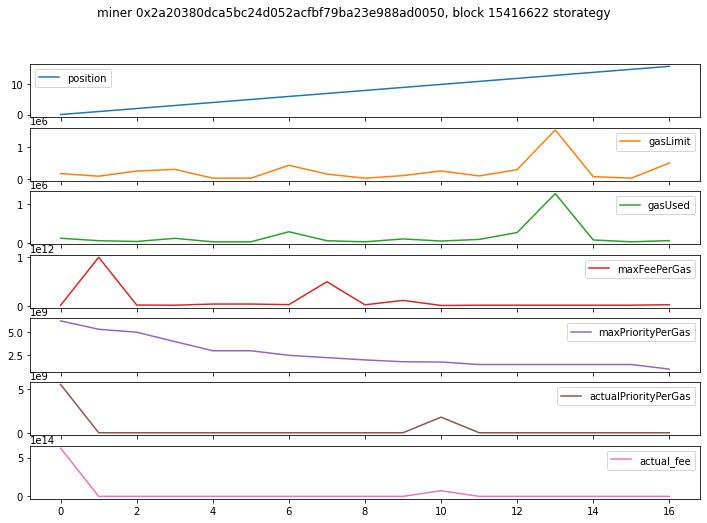

<Figure size 432x288 with 0 Axes>

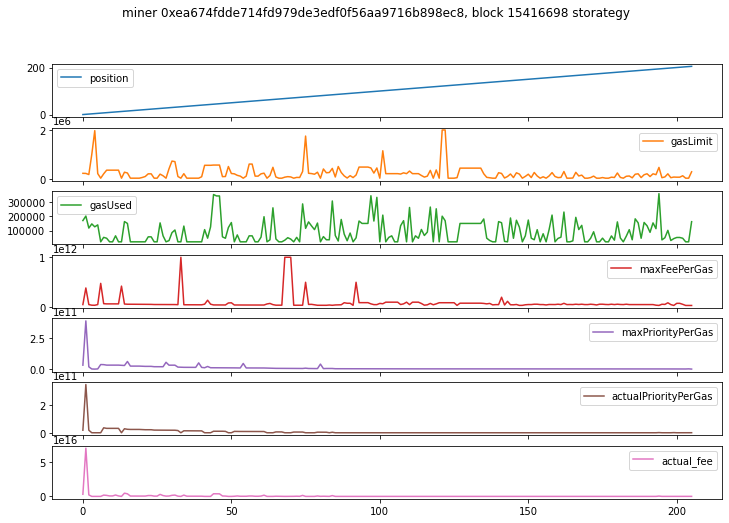

<Figure size 432x288 with 0 Axes>

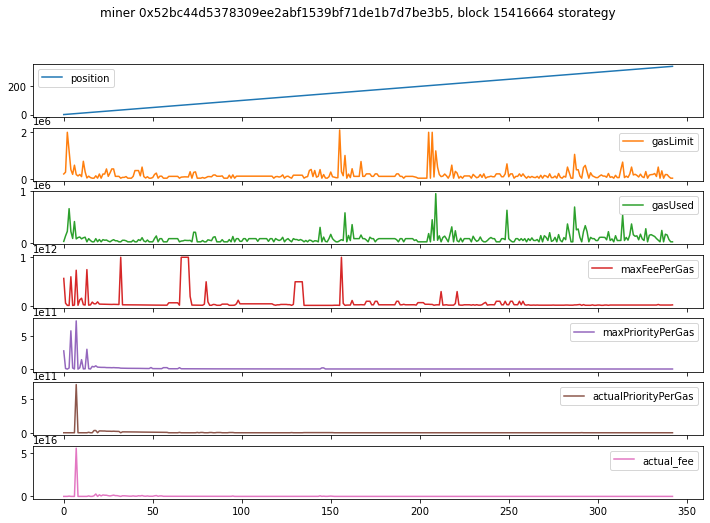

<Figure size 432x288 with 0 Axes>

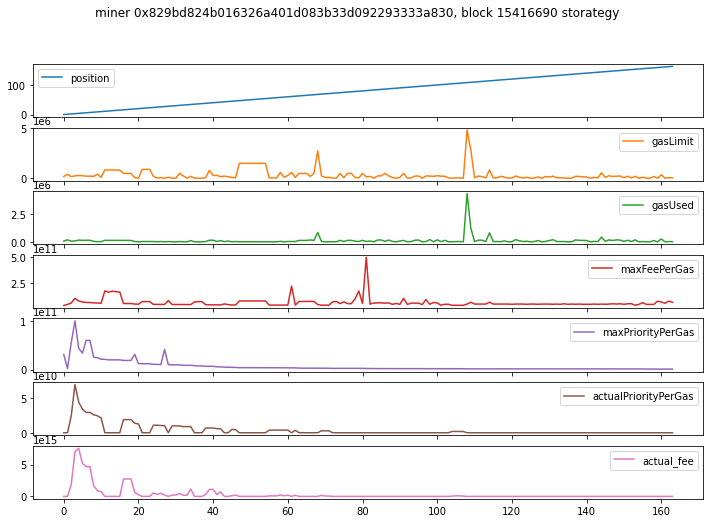

<Figure size 432x288 with 0 Axes>

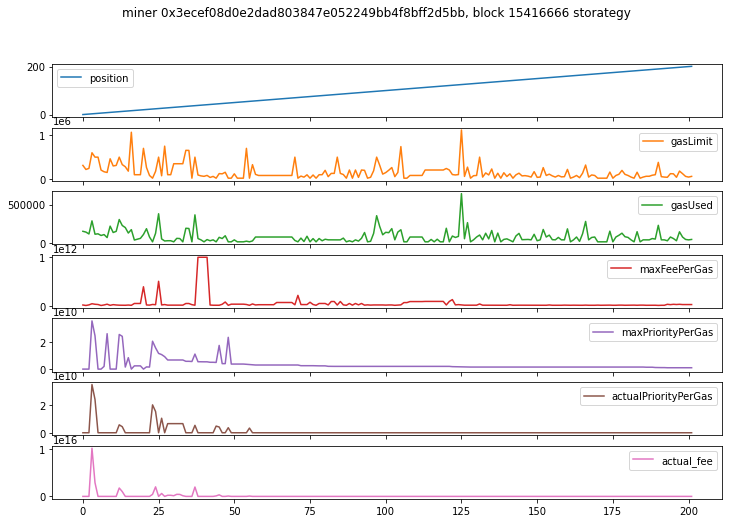

<Figure size 432x288 with 0 Axes>

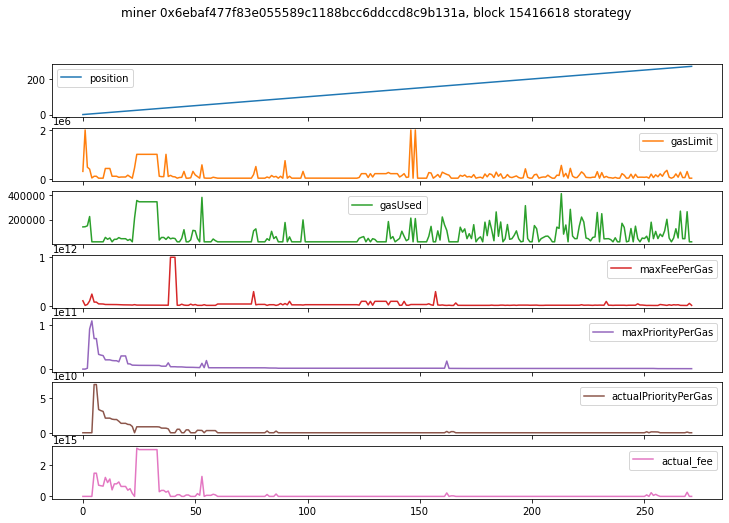

<Figure size 432x288 with 0 Axes>

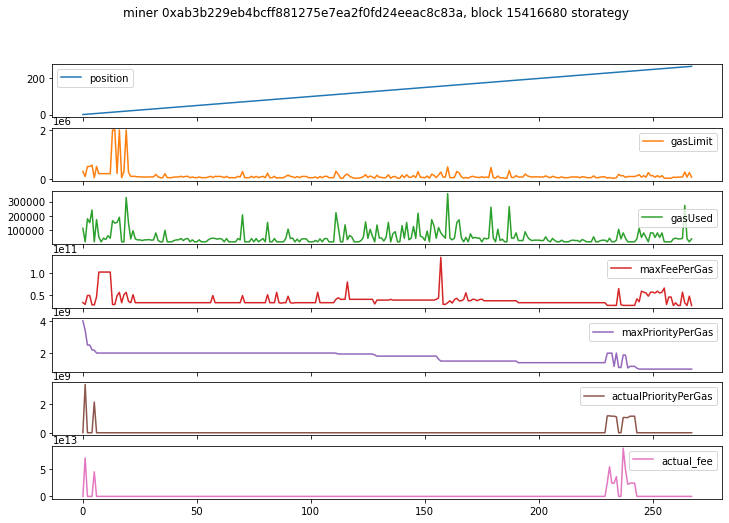

<Figure size 432x288 with 0 Axes>

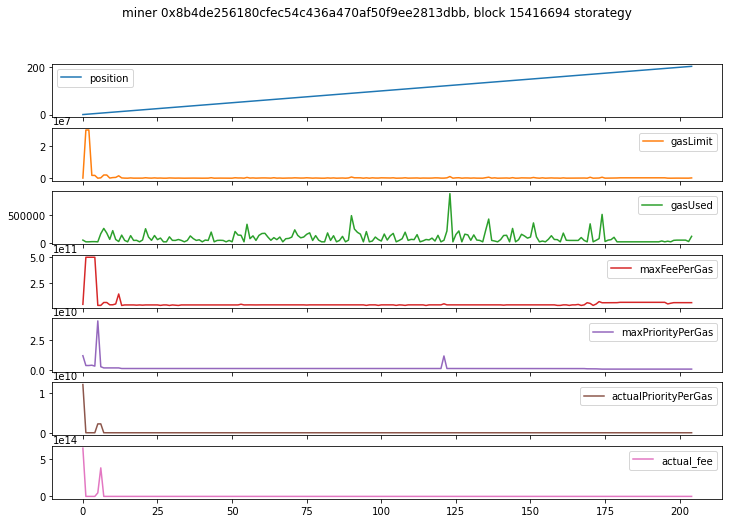

<Figure size 432x288 with 0 Axes>

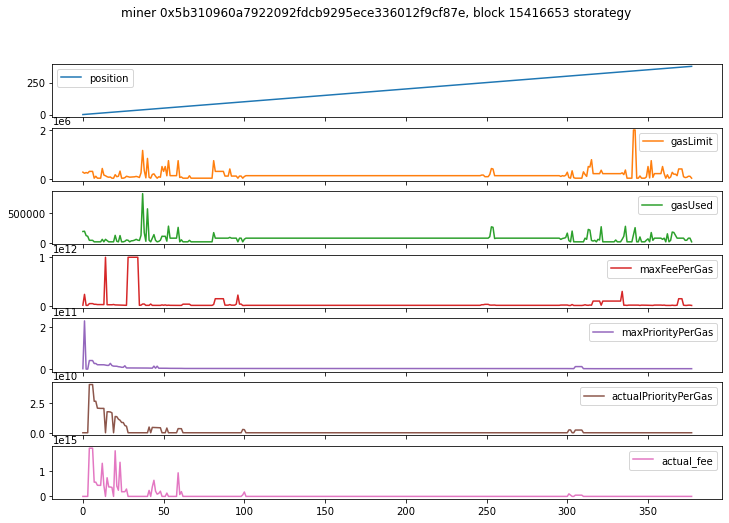

In [175]:
for target in list(miner_set)[0:20]:
    subdf = miners_df_dic[target].copy()
    bnum = subdf.index.values[0]
    print(f"(bnum={bnum}")
    
    subdf.index = range(0, len(subdf))
    
    plt.figure()
    subdf.plot(subplots=True, title=f"miner {target}, block {bnum} storategy", figsize=(12, 8))
    plt.savefig(f"miner_storategy_graph/{target}_{bnum}.png")
    # plt.close('all')
    
print("completede!")